<a href="https://colab.research.google.com/github/acesur/Machine-Learning-/blob/main/02_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000
Path 1 exists: True
Path 2 exists: True
Metadata exists: True
Metadata shape: (10015, 7)
Metadata columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']
Sampled metadata distribution:
dx
akiec    142
bcc      142
bkl      142
mel      142
nv       142
vasc     142
df       115
Name: count, dtype: int64


<ipython-input-1-0084400f9b2a>:121: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metadata_sampled = metadata.groupby('dx', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size // 7), random_state=42))


Processed 9950/967 images, Success: 136, Failures: 0
Processed 10000/967 images, Success: 141, Failures: 0
Processed 2750/967 images, Success: 200, Failures: 0
Processed 2600/967 images, Success: 202, Failures: 0
Processed 2700/967 images, Success: 214, Failures: 0
Processed 2900/967 images, Success: 261, Failures: 0
Processed 950/967 images, Success: 332, Failures: 0
Processed 200/967 images, Success: 363, Failures: 0
Processed 400/967 images, Success: 386, Failures: 0
Processed 600/967 images, Success: 389, Failures: 0
Processed 300/967 images, Success: 405, Failures: 0
Processed 50/967 images, Success: 408, Failures: 0
Processed 1100/967 images, Success: 428, Failures: 0
Processed 1200/967 images, Success: 479, Failures: 0
Processed 1150/967 images, Success: 499, Failures: 0
Processed 1300/967 images, Success: 553, Failures: 0
Processed 1600/967 images, Success: 602, Failures: 0
Processed 1350/967 images, Success: 660, Failures: 0
Processed 4150/967 images, Success: 724, Failures: 0

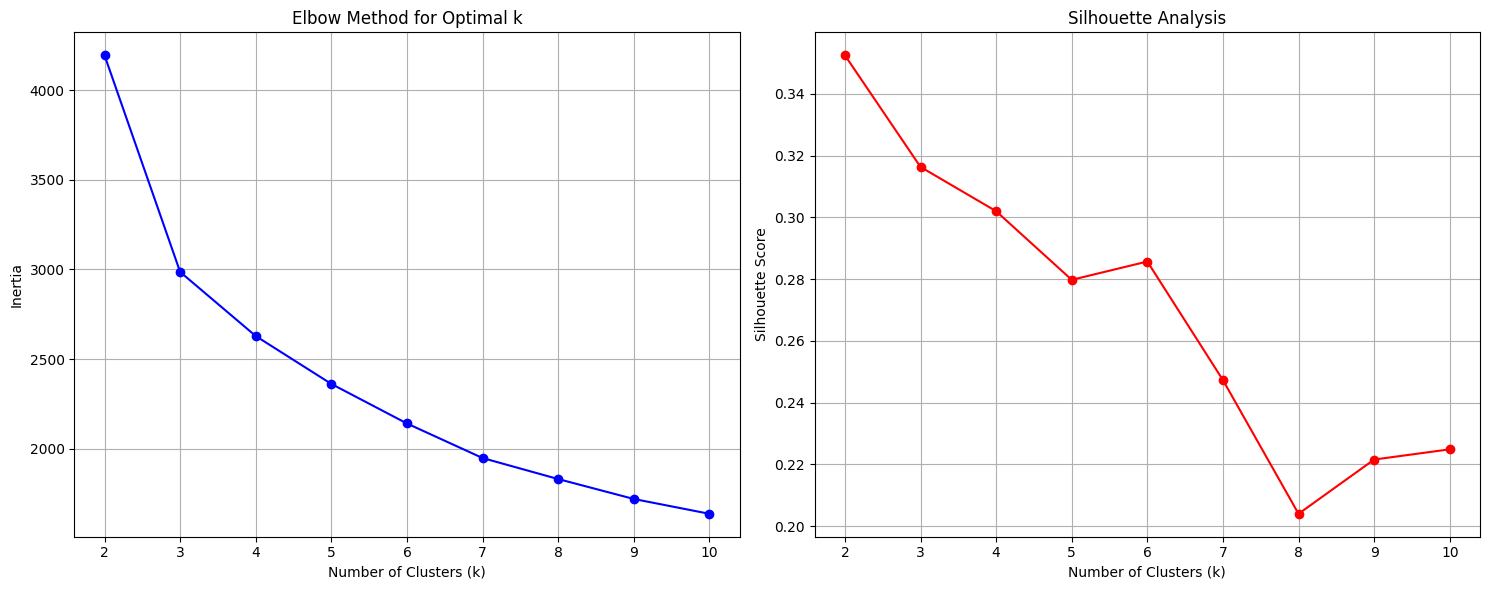


Applying K-means clustering with k=7

Cluster vs Diagnosis Cross-tabulation:
dx       akiec  bcc  bkl  df  mel  nv  vasc
cluster                                    
0           11   17   18   7   34  15     6
1           53   21   24  19    4   1    12
2           21   40   48  32   56  85    74
3            6   15    7   9    2   5     3
4            5   14    7   5   18  13    26
5            3    5    3   3    5   1     9
6           43   30   35  40   23  22    12

Average Cluster Purity: 0.298

PRINCIPAL COMPONENT ANALYSIS


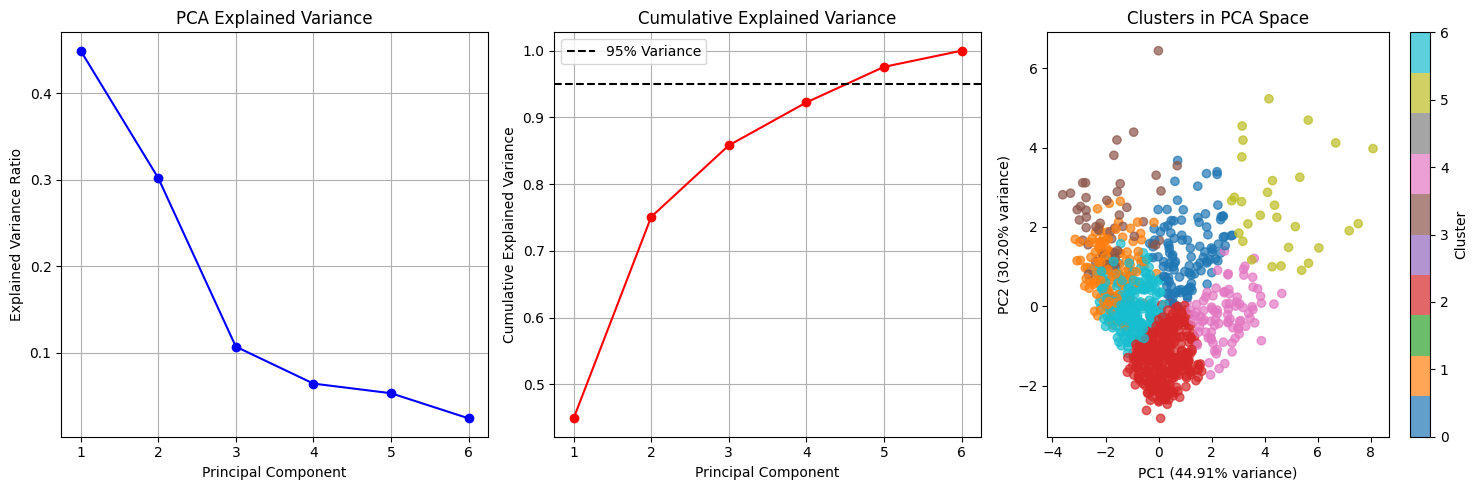

<ipython-input-1-0084400f9b2a>:301: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=plt.cm.tab10(i), label=dx, alpha=0.7)


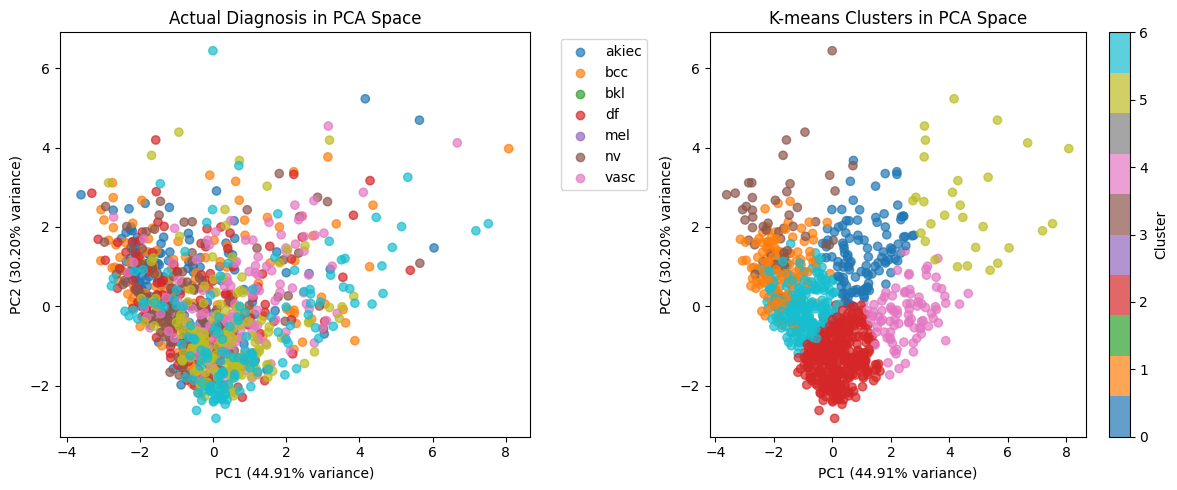


PCA Insights:
First 2 components explain 75.10% of variance
First 3 components explain 85.81% of variance
95% variance explained by 5 components

Feature Loadings (First 2 Components):
                       PC1    PC2
asymmetry           -0.331  0.439
border_irregularity -0.277  0.465
color_variance_r     0.478  0.252
color_variance_g     0.528  0.278
color_variance_b     0.461  0.383
diameter            -0.308  0.551

Enhanced features saved with clustering information


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from glob import glob
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import regionprops, label
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
import kagglehub

# Download dataset
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", path)

IMAGES_PATH_PART1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMAGES_PATH_PART2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
METADATA_PATH = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

print(f"Path 1 exists: {os.path.exists(IMAGES_PATH_PART1)}")
print(f"Path 2 exists: {os.path.exists(IMAGES_PATH_PART2)}")
print(f"Metadata exists: {os.path.exists(METADATA_PATH)}")

metadata = pd.read_csv(METADATA_PATH)
print(f"Metadata shape: {metadata.shape}")
print(f"Metadata columns: {metadata.columns.tolist()}")

def find_image_path_improved(image_id, part1_path, part2_path):
    if image_id.startswith('ISIC_'):
        base_id = image_id
        numeric_id = image_id.replace('ISIC_', '')
    else:
        base_id = f"ISIC_{image_id}"
        numeric_id = image_id

    patterns = [
        f"{base_id}.jpg",
        f"{numeric_id}.jpg",
        f"{base_id.lower()}.jpg",
        f"{numeric_id.lower()}.jpg"
    ]

    for pattern in patterns:
        for directory in [part1_path, part2_path]:
            path = os.path.join(directory, pattern)
            if os.path.exists(path):
                return path

    for directory in [part1_path, part2_path]:
        possible_files = glob(os.path.join(directory, f"*{base_id}*"))
        if possible_files:
            return possible_files[0]
        possible_files = glob(os.path.join(directory, f"*{numeric_id}*"))
        if possible_files:
            return possible_files[0]

    return None

def extract_abcd_features_robust(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None

        height, width, _ = img.shape
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        _, thresh_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        thresh_adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                cv2.THRESH_BINARY_INV, 11, 2)

        for thresh in [thresh_otsu, thresh_adaptive]:
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                continue

            largest_contour = max(contours, key=cv2.contourArea)
            contour_area = cv2.contourArea(largest_contour)
            if contour_area < 100:
                continue

            mask = np.zeros_like(gray)
            cv2.drawContours(mask, [largest_contour], 0, 255, -1)

            h, w = mask.shape
            flipped_mask = cv2.flip(mask, 1)
            asymmetry = np.sum(np.abs(mask - flipped_mask)) / (h * w * 255)

            perimeter = cv2.arcLength(largest_contour, True)
            border_irregularity = perimeter**2 / (4 * np.pi * contour_area) if contour_area > 0 else 0

            r, g, b = cv2.split(img)
            mask_bool = mask > 0

            color_variance_r = np.var(r[mask_bool]) if np.sum(mask_bool) > 0 else 0
            color_variance_g = np.var(g[mask_bool]) if np.sum(mask_bool) > 0 else 0
            color_variance_b = np.var(b[mask_bool]) if np.sum(mask_bool) > 0 else 0

            x, y, w, h = cv2.boundingRect(largest_contour)
            diameter = max(w, h)

            return {
                'asymmetry': float(asymmetry),
                'border_irregularity': float(border_irregularity),
                'color_variance_r': float(color_variance_r),
                'color_variance_g': float(color_variance_g),
                'color_variance_b': float(color_variance_b),
                'diameter': float(diameter)
            }

        return None

    except Exception as e:
        print(f"Error in feature extraction: {str(e)}")
        return None

# Extract features using a diverse stratified sample
sample_size = 1000
metadata_sampled = metadata.groupby('dx', group_keys=False).apply(lambda x: x.sample(min(len(x), sample_size // 7), random_state=42))

print("Sampled metadata distribution:")
print(metadata_sampled['dx'].value_counts())

feature_results = []
success_count = 0
failure_count = 0

for i, row in metadata_sampled.iterrows():
    img_id = row['image_id']
    img_path = find_image_path_improved(img_id, IMAGES_PATH_PART1, IMAGES_PATH_PART2)
    if img_path:
        features = extract_abcd_features_robust(img_path)
        if features:
            features['image_id'] = img_id
            features['dx'] = row['dx']
            feature_results.append(features)
            success_count += 1
        else:
            failure_count += 1
    else:
        failure_count += 1

    if (i + 1) % 50 == 0:
        print(f"Processed {i + 1}/{len(metadata_sampled)} images, Success: {success_count}, Failures: {failure_count}")

print(f"Final count - Success: {success_count}, Failures: {failure_count}")

if feature_results:
    feature_df = pd.DataFrame(feature_results)
    print("Feature DataFrame shape:", feature_df.shape)
    print("Class distribution:")
    print(feature_df['dx'].value_counts())
    from google.colab import drive
    drive.mount('/content/drive/')
    feature_df.to_csv('/content/drive/My Drive/abcd_features.csv', index=False)
else:
    print("No features were successfully extracted.")

# ADD THIS SECTION RIGHT AFTER YOUR EXISTING FEATURE EXTRACTION CODE
# (After: feature_df.to_csv('/content/drive/My Drive/abcd_features.csv', index=False))

if feature_results:
    feature_df = pd.DataFrame(feature_results)
    print("Feature DataFrame shape:", feature_df.shape)
    print("Class distribution:")
    print(feature_df['dx'].value_counts())

    # ============= NEW SECTION: CLUSTERING ANALYSIS =============
    print("\n" + "="*50)
    print("CLUSTERING ANALYSIS")
    print("="*50)

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # Prepare features for clustering
    feature_cols = ['asymmetry', 'border_irregularity', 'color_variance_r',
                   'color_variance_g', 'color_variance_b', 'diameter']
    X_cluster = feature_df[feature_cols].fillna(0)

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_cluster)

    # Determine optimal number of clusters using elbow method
    print("Determining optimal number of clusters...")
    inertias = []
    silhouette_scores = []
    k_range = range(2, 11)

    from sklearn.metrics import silhouette_score

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

    # Plot elbow curve and silhouette scores
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    ax1.plot(k_range, inertias, 'bo-')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method for Optimal k')
    ax1.grid(True)

    ax2.plot(k_range, silhouette_scores, 'ro-')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Apply K-means with optimal k (use k=7 to match diagnostic categories)
    optimal_k = 7
    print(f"\nApplying K-means clustering with k={optimal_k}")
    kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled)

    # Add cluster labels to dataframe
    feature_df['cluster'] = cluster_labels

    # Analyze cluster-diagnosis alignment
    cluster_diagnosis = pd.crosstab(feature_df['cluster'], feature_df['dx'])
    print("\nCluster vs Diagnosis Cross-tabulation:")
    print(cluster_diagnosis)

    # Calculate cluster purity
    cluster_purity = []
    for cluster_id in range(optimal_k):
        cluster_data = feature_df[feature_df['cluster'] == cluster_id]
        if len(cluster_data) > 0:
            most_common_class = cluster_data['dx'].mode()[0]
            purity = (cluster_data['dx'] == most_common_class).sum() / len(cluster_data)
            cluster_purity.append(purity)
        else:
            cluster_purity.append(0)

    print(f"\nAverage Cluster Purity: {np.mean(cluster_purity):.3f}")

    # ============= NEW SECTION: PCA ANALYSIS =============
    print("\n" + "="*50)
    print("PRINCIPAL COMPONENT ANALYSIS")
    print("="*50)

    # Apply PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Plot explained variance
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             pca.explained_variance_ratio_, 'bo-')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('PCA Explained Variance')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    plt.plot(range(1, len(cumsum) + 1), cumsum, 'ro-')
    plt.xlabel('Principal Component')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.axhline(y=0.95, color='k', linestyle='--', label='95% Variance')
    plt.legend()
    plt.grid(True)

    # Visualize clusters and actual diagnoses in PCA space
    plt.subplot(1, 3, 3)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Clusters in PCA Space')
    plt.colorbar(scatter, label='Cluster')

    plt.tight_layout()
    plt.show()

    # Show actual diagnosis distribution in PCA space
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    diagnosis_encoded = pd.Categorical(feature_df['dx']).codes
    scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=diagnosis_encoded, cmap='tab10', alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('Actual Diagnosis in PCA Space')

    # Create custom legend for diagnoses
    unique_diagnoses = feature_df['dx'].unique()
    for i, dx in enumerate(unique_diagnoses):
        plt.scatter([], [], c=plt.cm.tab10(i), label=dx, alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('K-means Clusters in PCA Space')
    plt.colorbar(scatter2, label='Cluster')

    plt.tight_layout()
    plt.show()

    # Print PCA insights
    print(f"\nPCA Insights:")
    print(f"First 2 components explain {cumsum[1]:.2%} of variance")
    print(f"First 3 components explain {cumsum[2]:.2%} of variance")
    print(f"95% variance explained by {np.argmax(cumsum >= 0.95) + 1} components")

    # Feature loadings for first two components
    feature_loadings = pd.DataFrame(
        pca.components_[:2].T,
        columns=['PC1', 'PC2'],
        index=feature_cols
    )
    print("\nFeature Loadings (First 2 Components):")
    print(feature_loadings.round(3))

    # Save enhanced features with cluster information
    feature_df.to_csv('/content/drive/My Drive/abcd_features_clustered.csv', index=False)
    print(f"\nEnhanced features saved with clustering information")

else:
    print("No features were successfully extracted.")
